## `Model_3`

### Target:
- Data Augumentation

### Results:
- Parameters: 7.9 K
- Best Train Accuracy: 99.01
- Best Test Accuracy: 99.4

### Analysis:
- augumentation helps a lot


# Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [18]:
# Train Phase transformations
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(0)),
    transforms.ElasticTransform(60.0, 5.0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

# Test Phase transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])


# Dataset and Creating Train/Test Split

In [21]:
from utils import prepare_mnist_data
train_loader, test_loader = prepare_mnist_data(
    train_transforms, test_transforms, batch_size=128)

<class 'torchvision.datasets.mnist.MNIST'>
CUDA Available? False


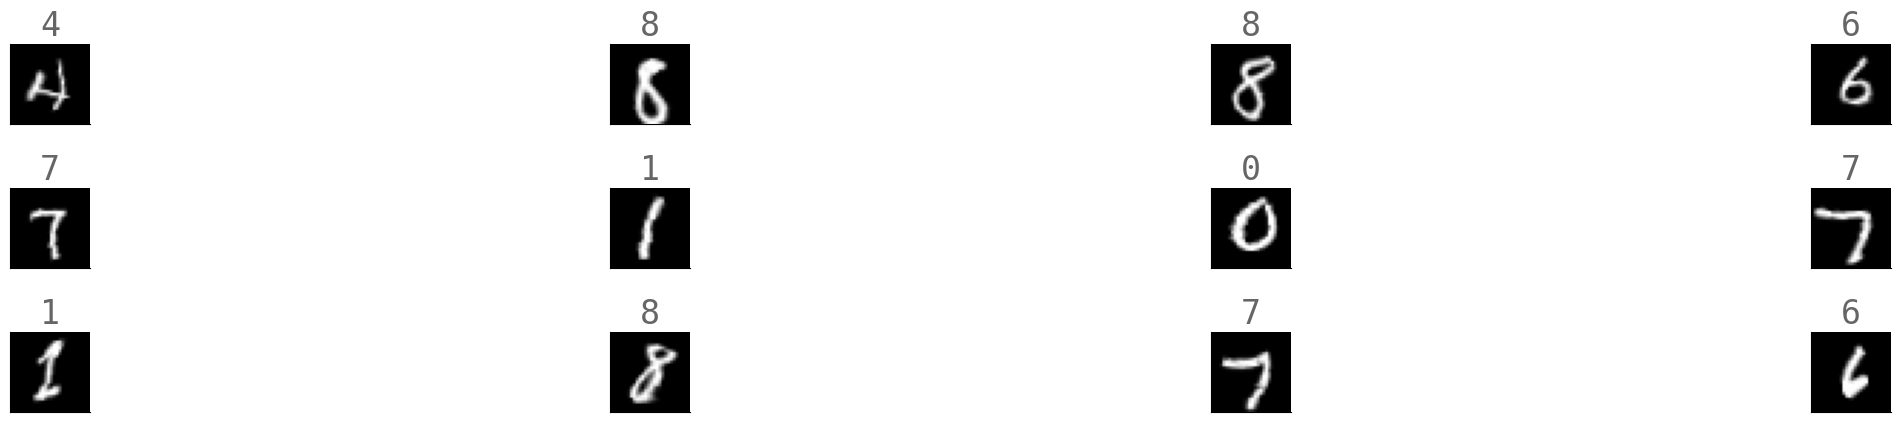

In [22]:
from utils import plot_img_batch
plot_img_batch(train_loader, n_img=12)

# The model

In [26]:
from torchsummary import summary
from model import Net
use_cuda = torch.cuda.is_available()
device = 'mps:0'
print(device)
network = Net(
    list('CCCPcCCCPcCCCPcCCcGc'),
    [8, 8, 16, 16,
     4, 16, 8, 16, 16,
     4, 16, 8, 16, 16,
     4, 16, 8, 8,
     8, 10],
    dropout_value=0.03).to('cpu')
summary(network, input_size=(1, 28, 28))

mps:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
           Dropout-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             576
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
           Dropout-8            [-1, 8, 28, 28]               0
            Conv2d-9           [-1, 16, 28, 28]           1,152
             ReLU-10           [-1, 16, 28, 28]               0
      BatchNorm2d-11           [-1, 16, 28, 28]              32
          Dropout-12           [-1, 16, 28, 28]               0
        MaxPool2d-13           [-1, 16, 14, 14]               0
           Conv2d-14            [

# Training and Testing

In [27]:
from torch.optim.lr_scheduler import StepLR
from model import train, test
network =  network.to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.95)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(network, device, train_loader, optimizer)
    test(network, device, test_loader)
    scheduler.step()

EPOCH: 0


Loss=0.17711128294467926 Batch_id=468 Accuracy=78.56: 100%|██████████| 469/469 [00:33<00:00, 14.15it/s]



Test set: Average loss: 0.1325, Accuracy: 9650/10000 (96.50%)

EPOCH: 1


Loss=0.05694350227713585 Batch_id=468 Accuracy=95.00: 100%|██████████| 469/469 [00:31<00:00, 14.79it/s] 



Test set: Average loss: 0.0559, Accuracy: 9833/10000 (98.33%)

EPOCH: 2


Loss=0.09643950313329697 Batch_id=468 Accuracy=96.16: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s] 



Test set: Average loss: 0.0467, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.1427459865808487 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:31<00:00, 14.99it/s]  



Test set: Average loss: 0.0302, Accuracy: 9906/10000 (99.06%)

EPOCH: 4


Loss=0.06796965003013611 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:32<00:00, 14.52it/s] 



Test set: Average loss: 0.0408, Accuracy: 9871/10000 (98.71%)

EPOCH: 5


Loss=0.04992135241627693 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:32<00:00, 14.31it/s] 



Test set: Average loss: 0.0210, Accuracy: 9931/10000 (99.31%)

EPOCH: 6


Loss=0.05464388057589531 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:32<00:00, 14.44it/s] 



Test set: Average loss: 0.0206, Accuracy: 9932/10000 (99.32%)

EPOCH: 7


Loss=0.08550087362527847 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:32<00:00, 14.51it/s] 



Test set: Average loss: 0.0194, Accuracy: 9934/10000 (99.34%)

EPOCH: 8


Loss=0.0393143929541111 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s]  



Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 9


Loss=0.0700196698307991 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:31<00:00, 14.98it/s]  



Test set: Average loss: 0.0190, Accuracy: 9938/10000 (99.38%)

EPOCH: 10


Loss=0.014622729271650314 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:32<00:00, 14.60it/s]



Test set: Average loss: 0.0187, Accuracy: 9942/10000 (99.42%)

EPOCH: 11


Loss=0.16623516380786896 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s] 



Test set: Average loss: 0.0185, Accuracy: 9937/10000 (99.37%)

EPOCH: 12


Loss=0.08754052966833115 Batch_id=468 Accuracy=97.92: 100%|██████████| 469/469 [00:31<00:00, 14.93it/s] 



Test set: Average loss: 0.0185, Accuracy: 9939/10000 (99.39%)

EPOCH: 13


Loss=0.007192691322416067 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:32<00:00, 14.54it/s]



Test set: Average loss: 0.0181, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.016960039734840393 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:31<00:00, 14.85it/s]



Test set: Average loss: 0.0183, Accuracy: 9940/10000 (99.40%)



In [5]:
from torch.optim.lr_scheduler import StepLR
from model import train, test
network =  network.to(device)
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.95)
scheduler = StepLR(optimizer, step_size=4, gamma=0.4)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(network, device, train_loader, optimizer)
    test(network, device, test_loader)

EPOCH: 0


Loss=0.3173380494117737 Batch_id=468 Accuracy=74.33: 100%|██████████| 469/469 [00:36<00:00, 12.96it/s] 



Test set: Average loss: 0.1003, Accuracy: 9738/10000 (97.38%)

EPOCH: 1


Loss=0.07103564590215683 Batch_id=468 Accuracy=95.28: 100%|██████████| 469/469 [00:31<00:00, 14.83it/s] 



Test set: Average loss: 0.0539, Accuracy: 9863/10000 (98.63%)

EPOCH: 2


Loss=0.17489033937454224 Batch_id=468 Accuracy=96.33: 100%|██████████| 469/469 [00:32<00:00, 14.28it/s] 



Test set: Average loss: 0.0648, Accuracy: 9793/10000 (97.93%)

EPOCH: 3


Loss=0.07772741466760635 Batch_id=468 Accuracy=96.68: 100%|██████████| 469/469 [00:32<00:00, 14.42it/s] 



Test set: Average loss: 0.0382, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.13719986379146576 Batch_id=468 Accuracy=97.12: 100%|██████████| 469/469 [00:32<00:00, 14.45it/s] 



Test set: Average loss: 0.0352, Accuracy: 9892/10000 (98.92%)

EPOCH: 5


Loss=0.19523878395557404 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:32<00:00, 14.28it/s] 



Test set: Average loss: 0.0330, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.15150833129882812 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:33<00:00, 14.04it/s] 



Test set: Average loss: 0.0286, Accuracy: 9910/10000 (99.10%)

EPOCH: 7


Loss=0.24156512320041656 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:32<00:00, 14.26it/s] 



Test set: Average loss: 0.0297, Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.03101339377462864 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:33<00:00, 14.15it/s] 



Test set: Average loss: 0.0260, Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.12109038978815079 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:33<00:00, 13.89it/s] 



Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.08688662201166153 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:33<00:00, 14.07it/s] 



Test set: Average loss: 0.0305, Accuracy: 9912/10000 (99.12%)

EPOCH: 11


Loss=0.0517665259540081 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:33<00:00, 14.19it/s]  



Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.12079960107803345 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:32<00:00, 14.57it/s] 



Test set: Average loss: 0.0288, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.0869532898068428 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:32<00:00, 14.36it/s]   



Test set: Average loss: 0.0220, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.05673931911587715 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:33<00:00, 14.04it/s] 



Test set: Average loss: 0.0197, Accuracy: 9938/10000 (99.38%)

